##  Decoding Data Science Job Postings Notebook 2


The jobs dataset is a really tiny dataset so we can just add items to the bottom of the dataset

Import libraries

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random

import os
from pathlib import Path

import re
from IPython.core.display import display, HTML
from bs4 import BeautifulSoup as bs

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import KMeans

from wordcloud import WordCloud

import warnings
warnings.filterwarnings('ignore')

### Helper Functions for Input and Clustering

In [2]:
def render(html_string):
    display(HTML(html_string))
    
cur_path = Path()

random.seed(42)

trace = False

def rank_words(alist,ngram=(1,1)):
    vec = TfidfVectorizer(stop_words='english',ngram_range=ngram)
    tfidf_matrix = vec.fit_transform(alist).toarray()
    df = pd.DataFrame({'Words': vec.get_feature_names(),
                       'Summed TFIDF': tfidf_matrix.sum(axis=0)})
    sorted_df = df.sort_values('Summed TFIDF', ascending=False)
    return sorted_df

### Find the working files and stash them in a list

In [3]:
inputs = os.listdir('data/html_job_postings')
#inputs

### Construct the Data Frame

In [4]:
cols = ['Title','Body','Bullets']
jobs = pd.DataFrame(columns=cols)
jobs.head()

,Title,Body,Bullets


### Procesing loop

- Find the file
- Discard if not HTML
- Read the file, coercing all characters to latin-1
- Add the Title, Body and Bullet Points to the Data Frame

In [5]:
printcounter = 0
for fn in range(len (inputs)): 
    printcounter = printcounter + 1
    work = cur_path.joinpath('data','html_job_postings',inputs[fn])
    if printcounter == 73:
        print(fn,work)
        printcounter = 0
        
    #Only try to process html files
    if not (inputs[fn].endswith("html")) : continue

    with open(work, encoding='latin-1')as f:   #there are some unreadable char so coerce them
        wfile = f.read()
        soup = bs(wfile,'html.parser')
        title = soup.title.text
        #print(title)
        body = soup.find('body')
       
        blt = [bullet.text for bullet in soup.find_all('li')]
        jobs.loc[fn] = [title, soup.body.text,blt]
        f.close()
        
jobs.head()    

72 data\html_job_postings\0f296522af3385ec_fccid.html
145 data\html_job_postings\1c61a9e892e12f82_fccid.html
218 data\html_job_postings\267e7cf7de2959c7_fccid.html
291 data\html_job_postings\34ba2c8c3260ea5c_fccid.html
364 data\html_job_postings\41d38cfa6de4d386_fccid.html
437 data\html_job_postings\4eb2d96bd560f444_fccid.html
510 data\html_job_postings\5cca03b0bb1da997_fccid.html
583 data\html_job_postings\6b3083de64d2a9cb_fccid.html
656 data\html_job_postings\7a38c671a8ab6ccc_fccid.html
729 data\html_job_postings\85f95c9b6d5a2858_fccid.html
802 data\html_job_postings\9759be8d1a8f8e2e_fccid.html
875 data\html_job_postings\a504cad692be9d81_fccid.html
948 data\html_job_postings\b0e743047ca171e1_fccid.html
1021 data\html_job_postings\be3d5c9e7eaccaab_fccid.html
1094 data\html_job_postings\d0417e8d5ed8f3c2_fccid.html
1167 data\html_job_postings\deef568e04822e3a_fccid.html
1240 data\html_job_postings\ebc52ba388dc4cff_fccid.html
1313 data\html_job_postings\fae2d659bf165ede_fccid.html


,Title,Body,Bullets
0,"Data Engineer - Columbus, GA 31909","Data Engineer - Columbus, GA 31909\nCelebratin...",[Bachelorâs or Masterâs degree in statisti...
1,"Data Analyst - St. Louis, MO","Data Analyst - St. Louis, MO\nDuties\nSummary\...",[Job family (Series)\n1501 General Mathematics...
2,"Data Scientist - Newark, CA","Data Scientist - Newark, CA\nData Scientist\n\...","[ Design, develop, document and maintain machi..."
3,Patient Care Assistant / PCA - Med/Surg (Fayet...,Patient Care Assistant / PCA - Med/Surg (Fayet...,[Provides all personal care services in accord...
4,"Scientific Programmer - Berkeley, CA","Scientific Programmer - Berkeley, CA\nCaribou ...","[Demonstrated proficiency with Python, JavaScr..."


### How many got into the Data Frame

In [6]:
print (jobs.describe())

                                Title  \
count                            1336   
unique                           1237   
top     Data Scientist - New York, NY   
freq                               13   

                                                     Body Bullets  
count                                                1336    1336  
unique                                               1327    1146  
top     Staff Data Scientist - NLP - Sunnyvale, CA 940...      []  
freq                                                    2     121  


### Snatch out the bullets so we can look for matching skills

In [7]:
bullet_count = 0
for bullet_list in jobs.Bullets:
    if bullet_list:
        bullet_count += 1
            
pct_bult = 100 * bullet_count / jobs.shape[0]
print(f"{pct_bult:.2f}% of the postings contain bullets")

90.94% of the postings contain bullets


### What words are in the Bullets

For this version we will select unigrams and bigrams

Data Scientist is a bigram

In [8]:
words_in_bullets = []
# Glom thenm all into one big list
for bullet_list in jobs.Bullets:
    words_in_bullets.extend(bullet_list)

sorted_df = rank_words(words_in_bullets,(1,2))
print(sorted_df[:15].to_string(index=False))

            Words  Summed TFIDF
       experience    467.614252
             data    445.838260
           skills    236.909637
         learning    203.223395
         analysis    194.986147
             work    192.319752
          ability    189.590100
            years    185.998230
         business    169.363003
           python    164.017463
          science    162.419706
        knowledge    161.409134
          machine    159.176014
           strong    158.694581
 machine learning    155.413210


### Looks like some fluff here, compare to the body

In [9]:
not_a_bullet = []

printcounter = 0
for fn in range(len (inputs)): 
    printcounter = printcounter + 1
    work = cur_path.joinpath('data','html_job_postings',inputs[fn])
    if printcounter == 131:
        print(fn,work)
        printcounter = 0
        
    #Only try to process html files
    if not (inputs[fn].endswith("html")) : continue

    with open(work, encoding='latin-1')as f:   #there are some unreadable char so coerce them
        wfile = f.read()
        soup = bs(wfile,'html.parser')

        #print(title)
        body = soup.find('body')
        for tag in body.find_all('li'):
            tag.decompose()
            
        not_a_bullet.append(body.text)
       
        
        f.close()
print (len(not_a_bullet))        
sort_df = rank_words(not_a_bullet, (1,2))    
print (sort_df[:15].to_string(index=False))

130 data\html_job_postings\197da59b3b0f3101_fccid.html
261 data\html_job_postings\2e35838a2695eeac_fccid.html
392 data\html_job_postings\48eb9d0a903a4218_fccid.html
523 data\html_job_postings\5f700bf168c15336_fccid.html
654 data\html_job_postings\79f708c2e52b35d7_fccid.html
785 data\html_job_postings\93f28a9036b209eb_fccid.html
916 data\html_job_postings\ab86516ee1d019c5_fccid.html
1047 data\html_job_postings\c62730ff8dd3076d_fccid.html
1178 data\html_job_postings\e15d058a38bc2073_fccid.html
1309 data\html_job_postings\f9ee01df580ba190_fccid.html
1336
          Words  Summed TFIDF
           data     54.603224
           team     21.784906
           work     21.613172
     experience     20.742905
       business     20.301578
      scientist     19.873819
 data scientist     19.020741
       learning     17.893805
      analytics     17.444637
         status     17.367948
       research     17.148125
            job     17.142890
 qualifications     16.745836
        science     16

### Look at titles 

In [10]:
words_in_titles = []
# Glom them all into one big list
for tit in jobs.Title:
    words_in_titles.append(tit)

sorted_df = rank_words(words_in_titles,(1,3))
print(sorted_df[:25].to_string(index=False))

              Words  Summed TFIDF
               data     55.598963
                 ca     49.747325
          scientist     47.591673
     data scientist     46.030401
                san     32.664055
      san francisco     27.949982
          francisco     27.949982
   san francisco ca     27.168153
       francisco ca     27.168153
           engineer     24.005686
            analyst     23.595380
             senior     18.163916
                 ny     15.667009
                new     15.227926
                 wa     14.532053
           new york     14.409413
               york     14.409413
            york ny     14.284960
        new york ny     14.284960
       data analyst     12.831349
            science     12.734695
      scientist san     12.527325
 data scientist san     12.245972
        senior data     12.163288
             intern     12.144145


### Too many addresses in top 15, split into separate columns

In [11]:
new = jobs['Title'].str.split("-",n=1, expand=True)

jobs["Short_Title"] = new[0]
jobs["Address"] = new[1]
jobs.head()

,Title,Body,Bullets,Short_Title,Address
0,"Data Engineer - Columbus, GA 31909","Data Engineer - Columbus, GA 31909\nCelebratin...",[Bachelorâs or Masterâs degree in statisti...,Data Engineer,"Columbus, GA 31909"
1,"Data Analyst - St. Louis, MO","Data Analyst - St. Louis, MO\nDuties\nSummary\...",[Job family (Series)\n1501 General Mathematics...,Data Analyst,"St. Louis, MO"
2,"Data Scientist - Newark, CA","Data Scientist - Newark, CA\nData Scientist\n\...","[ Design, develop, document and maintain machi...",Data Scientist,"Newark, CA"
3,Patient Care Assistant / PCA - Med/Surg (Fayet...,Patient Care Assistant / PCA - Med/Surg (Fayet...,[Provides all personal care services in accord...,Patient Care Assistant / PCA,"Med/Surg (Fayette, AL) - Fayette, AL"
4,"Scientific Programmer - Berkeley, CA","Scientific Programmer - Berkeley, CA\nCaribou ...","[Demonstrated proficiency with Python, JavaScr...",Scientific Programmer,"Berkeley, CA"


### Rerun TFIDF in Short_Title


In [12]:
words_in_stitles = []
# Glom them all into one big list
for tit in jobs.Short_Title:
    words_in_stitles.append(tit)

sorted_df = rank_words(words_in_stitles,(1,3))
print(sorted_df[:25].to_string(index=False))

                 Words  Summed TFIDF
                  data    162.155816
        data scientist    160.158787
             scientist    159.134143
               analyst     47.311590
              engineer     45.249519
                senior     34.737671
          data analyst     28.857728
           senior data     27.369517
                intern     26.030550
 senior data scientist     25.511197
               manager     21.882144
         data engineer     20.090322
               science     18.862914
          data science     17.930945
             analytics     17.874671
              learning     16.900374
               machine     16.153345
      machine learning     15.468567
              software     15.368118
              research     14.656206
             associate     13.133991
     software engineer     12.069723
              director     10.747593
              language     10.513415
             assistant     10.290034


### Look for just Data Scientist in titles


In [13]:
reg = r'data scien(ce|tist)'
not_data_science = jobs[~jobs.Short_Title.str.contains(reg, case=False)]

pct_not_ds = (not_data_science.shape[0]/jobs.shape[0])*100

print(f"{pct_not_ds:.3f}% of jobs are not Data Scinece related/n")

for tit in not_data_science.Short_Title[:20]:
    print(tit)

64.820% of jobs are not Data Scinece related/n
Data Engineer 
Data Analyst 
Patient Care Assistant / PCA 
Scientific Programmer 
JD Digits 
PwC Labs 
Data and Reporting Analyst 
Senior Manager Advanced Analytics 
Data Specialist, Product Support Operations 
Deep Learning Engineer 
Research Intern, 2020 
Analytical Lead 
Interlibrary Projects Assistant (6760C) 27525 
Strategy Analyst 
Software Developer 
Critical Targeting Network Analyst 2 
Impact and Learning Manager 
Software Engineering Intern 
Quantitative Business Analyst, Geo 
Senior Machine Learning (ML) and Computer Vision (CV) Engineer 


### Who do they want for these ersatz jobs


In [14]:
i=0
blts = not_data_science.Bullets[i]
print("\n***\n",not_data_science.Short_Title[i])
for j, blt in enumerate(blts[:5]):
    print(f"{j}: {blt.strip()}")


***
 Data Engineer 
0: Bachelorâs or Masterâs degree in statistics, operations research, computer science, physics or related discipline
1: 2+ years of industry experience in a technical role, preferably in a data science capacity
2: Good knowledge of R or Python or Spark
3: Knowledge of the following: Generalized Linear and Non-Linear Models, Time Series Analysis, Random Forest, Gradient Boosted Machines, Neural Networks, Unsupervised Methods (Dimensionality Reduction, Clustering, etc.)
4: Experience querying relational data systems for ETL and data integration tasks


In [15]:
not_data_science.head()

,Title,Body,Bullets,Short_Title,Address
0,"Data Engineer - Columbus, GA 31909","Data Engineer - Columbus, GA 31909\nCelebratin...",[Bachelorâs or Masterâs degree in statisti...,Data Engineer,"Columbus, GA 31909"
1,"Data Analyst - St. Louis, MO","Data Analyst - St. Louis, MO\nDuties\nSummary\...",[Job family (Series)\n1501 General Mathematics...,Data Analyst,"St. Louis, MO"
3,Patient Care Assistant / PCA - Med/Surg (Fayet...,Patient Care Assistant / PCA - Med/Surg (Fayet...,[Provides all personal care services in accord...,Patient Care Assistant / PCA,"Med/Surg (Fayette, AL) - Fayette, AL"
4,"Scientific Programmer - Berkeley, CA","Scientific Programmer - Berkeley, CA\nCaribou ...","[Demonstrated proficiency with Python, JavaScr...",Scientific Programmer,"Berkeley, CA"
5,JD Digits - AI Lab Research Intern - Mountain ...,JD Digits - AI Lab Research Intern - Mountain ...,[Conduct state-of-the-art research in machine ...,JD Digits,"AI Lab Research Intern - Mountain View, CA"


### Now that we have some idea about the data set, load the resume to compare

In [16]:
resume = open('resume.txt','r').read()
print (resume)

Experience

1. Developed probability simulations using NumPy.
2. Assessed online ad-clicks for statistical significance using Permutation testing.
3. Analyzed disease outbreaks using common clustering algorithms.

Additional Skills

1. Data visualization using Matplotlib.
2. Statistical analysis using SciPy.
3. Processing structured tables using Pandas.
4. Executing K-Means clustering and DBSCAN clustering using Scikit-Learn.
5. Extracting locations from text using GeonamesCache.
6. Location analysis and visualization using GeonamesCache and Basemap.
7. Dimensionality reduction with PCA and SVD, using Scikit-Learn.
8. NLP analysis and text topic detection using Scikit-Learn.


### Do a TFIDF on the Jobs Body and the resume

In [17]:
combined_text = jobs.Body.values.tolist() + [resume]
vec = TfidfVectorizer(stop_words='english')
combined_matrix = vec.fit_transform(combined_text).toarray()

In [18]:
combined_matrix.shape

(1337, 19488)

### Do a cosine similarities on all but resume and resume

In [19]:
cos_sim = combined_matrix[:-1] @ combined_matrix[-1]

In [20]:
jobs['Relevant'] = cos_sim

### Look at the bottom ones first - not similar to resume

In [21]:
rel_jobs = jobs.sort_values('Relevant', ascending=False)
for tit in rel_jobs[-25:].Short_Title:
    print(tit)

Academic Personnel & HR Coordinator (7715U) 
Sales Executive 
Personal Care Assistant 
Blockchain Analyst 
Finance Consultant 
Quantitative Consumer and Product Modeler 
Software DeveloperâNatural Language Processing 
Research Intern, 2020 
QSR Store Assistant 
QSR Store Assistant 
MAINTENANCE LEADPERSON~SI4241~5204 
Director of Marketing 
TG Shift Supervisor 
Software Engineer 
Growth and Competition Analyst 
NoSQL Database Administrator 
Manager 
Product Manager 
Scorekeeper 
Dev Ops Engineer AWS 
Part
Juvenile Institution Officer I 
Page Not Found 
Director of Econometric Modeling 
Page Not Found 


### The top items are more relevant

In [22]:
for tit in rel_jobs[:20].Short_Title:
    print(tit)

Chief Data Officer 
Data Scientist 
Data Scientist 
Senior Data Scientist 
Data Scientist (PhD) 
Associate Data Scientist (BS / MS) 
Data Scientist (PhD) 
Data Scientist 
Data Scientist 
Data Science Intern (BS / MS) 
Data Science Analyst 
Machine Learning Engineer 
Data Architect 
Sr Data Scientist. 
Data Scientist 
Data Scientist 
Mathematical and Statistical Scientist* 
Lead Data Scientist 
Automation Spoc 
Talend Automation spoc 


In [23]:
rel_jobs.head()

,Title,Body,Bullets,Short_Title,Address,Relevant
1033,"Chief Data Officer - Culver City, CA 90230","Chief Data Officer - Culver City, CA 90230\nMe...",[Work with stakeholders throughout the organiz...,Chief Data Officer,"Culver City, CA 90230",0.163167
530,"Data Scientist - Beavercreek, OH","Data Scientist - Beavercreek, OH\nData Scienti...",[Use statistical research methods to analyze d...,Data Scientist,"Beavercreek, OH",0.141606
25,"Data Scientist - San Diego, CA","Data Scientist - San Diego, CA\nJob Title: Dat...",[\nWork with stakeholders throughout the organ...,Data Scientist,"San Diego, CA",0.140131
955,"Senior Data Scientist - New York, NY 10018","Senior Data Scientist - New York, NY 10018\nOv...",[Work with stakeholders to identify opportunit...,Senior Data Scientist,"New York, NY 10018",0.137802
555,"Data Scientist (PhD) - Spring, TX","Data Scientist (PhD) - Spring, TX\nJob Summary...","[Apply statistical analysis, pattern recogniti...",Data Scientist (PhD),"Spring, TX",0.134205


### Graph the relevance

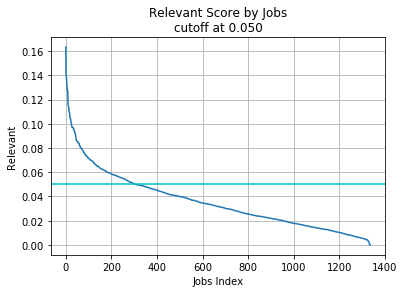

In [25]:
plt.plot(range(rel_jobs.shape[0]),rel_jobs.Relevant.values)
#set a cutoff at 0.050
plt.axhline(y=0.05, c='c')
plt.title('Relevant Score by Jobs\ncutoff at 0.050')
plt.ylabel("Relevant")
plt.xlabel('Jobs Index')
plt.grid(True)
plt.show()

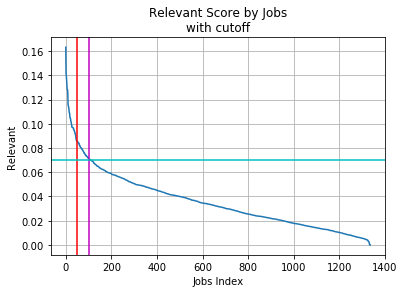

In [26]:
plt.plot(range(rel_jobs.shape[0]),rel_jobs.Relevant.values)
plt.title('Relevant Score by Jobs\nwith cutoff')
plt.ylabel("Relevant")
plt.xlabel('Jobs Index')
plt.axvline(x=100, c='m')
plt.axvline(x=50, c='r')
plt.axhline(y=0.07, c='c')
plt.grid(True)
plt.show()

### Look at the job titles between 50 and 100


In [27]:
for tit in rel_jobs[50:100].Short_Title:
    print(tit)

Data Science Instructor 
Data Scientist and Visualization Specialist 
Data Analyst and Data Scientist 
NASA SMAEC Data Scientist 
Data Scientist I 
Sr. Data Scientist(NLP) 
Data Scientist 
Data Analytics and Insights Specialist 
Data Scientist 
Data Scientist 
Jr. Data Scientist 
Data Scientist, Growth Data Science 
Associate Scientist, Data Science 
Senior Data Scientist 
Data Scientist 
Data Analyst 
Data Scientist / ML Engineer 
Sr. Data Scientist 
2019
Data Scientist 
Data Scientist 
Data Analyst 
Scientist I, Bioinformatics 
Manager, Data Science, Programming and Visualization 
Natural Language Processing Engineer 
Senior Machine Learning Engineer (NLP) 
Data Scientist, Applied Machine Learning 
Analytics, Retail Marketing Analyst 
Machine Learning Engineer (NLP) 
Data Engineer 
Physics Data Scientist 
Physics Data Scientist 
Data Scientist 
Data Science Software Engineer 
IT Data Scientist 
Data Scientist 
Data Scientist 
Full Time Opportunities for Students or Recent Graduates: 

### Look at the job titles between 100 and 200


In [28]:
for tit in rel_jobs[100:200].Short_Title:
    print(tit)

Data & Applied Scientist 
Senior Quantitative Modeler (San Francisco, CA) 
Data Scientist 
Data Engineer 
Statistical Analyst 
Research Scientist, Computational Genomics (Single Cell Characterization) 
Data Scientist 
Senior Data Visualization Scientist 
Data Scientist 
Natural Language Processing Scientist 
Director of Analytics 
Data Scientist, Engineering 
Senior Data Scientist 
Research Associate 
Data Scientist, Engineering 
Data Scientist 
A.I. Specialist 
Senior Data Analyst 
Data Analyst 
People Research Scientist, Internal Communications 
Data Engineer 
Data Science Intern 
Data Scientist 
Data Scientist I 
Data Scientist 
Data Scientist 
2020 Intern 
Sr Data Scientist (Analytic Consultant 5) 
Temporary Data Analyst and Visualization Specialist, Center for Digital and Data Excellence 
Data Scientist 
Senior Data Scientist 
Machine Learning Engineer 
Senior Consulting Data Analyst 
Data Scientist 
Data Scientist 
Associate Data Scientist 
AI & Data 
Big Data / PySpark Engineer 

### Still finding Data Scienist at 200'th relevant job